In [ ]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

# Task 1. Algorithm's analysis

In [ ]:
import random
import time
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

### Generating graph

In [ ]:

# You can use this function to generate a random graph with 'num_of_nodes'
# nodes and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted
    (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

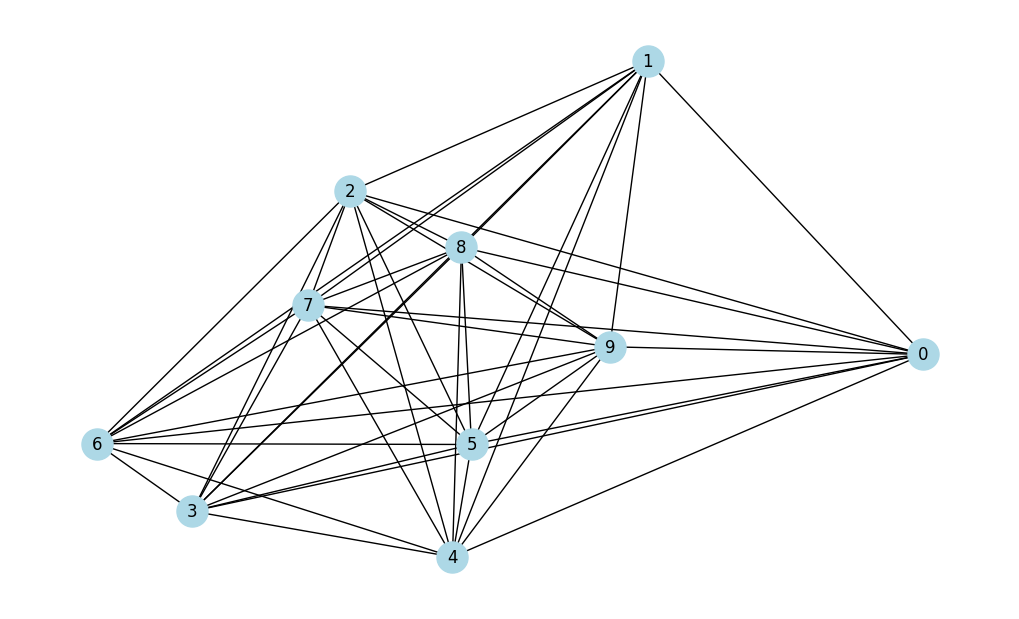

In [ ]:
G = gnp_random_connected_graph(10, 1, False, True)

## Subtask 1.1 (1 point)

### Kruskal's algorithm

#### nx implementation

In [ ]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

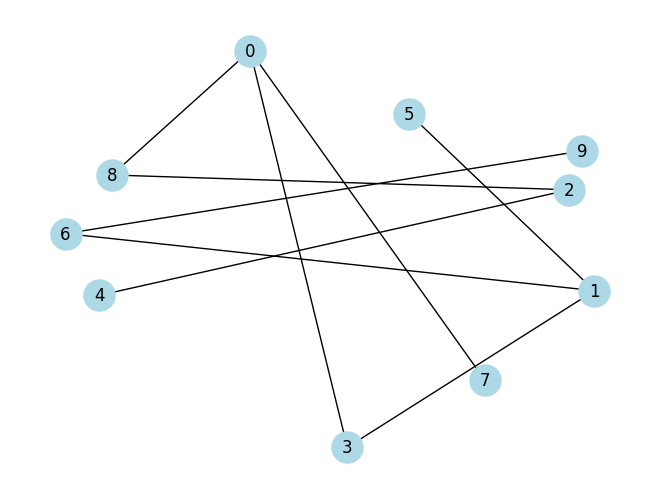

In [ ]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 3), (0, 7), (0, 8), (1, 6), (1, 3), (1, 5), (2, 4), (2, 8), (6, 9)]),
 9)

#### Your implementation

In [ ]:
class UnionFind:
    """
    Структура даних Union-Find (Disjoint Set Union) для ефективної перевірки циклів.
    """
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x == root_y:
            return False

        if self.rank[root_x] < self.rank[root_y]:
            self.parent[root_x] = root_y
        elif self.rank[root_x] > self.rank[root_y]:
            self.parent[root_y] = root_x
        else:
            self.parent[root_y] = root_x
            self.rank[root_x] += 1

        return True


def kruskal_mst(G):
    """
    Реалізація алгоритму Крускала для знаходження мінімального остовного дерева.

    Args:
        G: NetworkX граф з вагами ребер

    Returns:
        list: Список ребер у форматі (u, v, weight) що формують MST
    """
    edges = []
    for u, v, data in G.edges(data=True):
        weight = data.get('weight', 1)
        edges.append((weight, u, v))

    edges.sort()

    nodes = list(G.nodes())
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}

    uf = UnionFind(len(nodes))

    mst_edges = []

    for weight, u, v in edges:
        u_idx = node_to_idx[u]
        v_idx = node_to_idx[v]

        if uf.union(u_idx, v_idx):
            mst_edges.append((u, v, weight))

        if len(mst_edges) == len(nodes) - 1:
            break

    return mst_edges

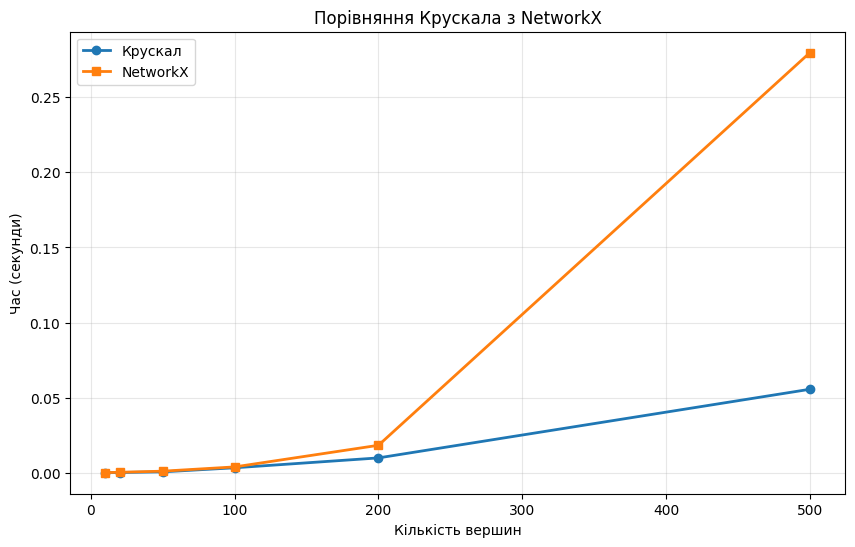

In [ ]:
node_sizes = [10, 20, 50, 100, 200, 500]
kruskal_times = []
nx_times_1 = []

for n in node_sizes:
    G = gnp_random_connected_graph(n, 0.5)

    start = time.perf_counter()
    kruskal_mst(G)
    kruskal_time = time.perf_counter() - start
    kruskal_times.append(kruskal_time)

    start = time.perf_counter()
    list(nx.minimum_spanning_edges(G))
    nx_time = time.perf_counter() - start
    nx_times_1.append(nx_time)

plt.figure(figsize=(10, 6))
plt.plot(node_sizes, kruskal_times, marker='o', label='Крускал', linewidth=2)
plt.plot(node_sizes, nx_times_1, marker='s', label='NetworkX', linewidth=2)
plt.xlabel('Кількість вершин')
plt.ylabel('Час (секунди)')
plt.title('Порівняння Крускала з NetworkX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Висновок: алгоритм Крускала у власній реалізації демонструє стабільну роботу, проте
природно поступається оптимізованій версії NetworkX за швидкістю виконання.
Ключовою особливістю алгоритму Крускала є необхідність сортування всіх ребер
графа за вагою, після чого ми жадібно додаємо найлегші ребра, що не утворюють
циклів. Саме для ефективної перевірки циклів використовується структура даних
Union-Find або Disjoint Set Union.

DSU є критично важливою для алгоритму Крускала, оскільки вона дозволяє
перевіряти, чи утворить додавання нового ребра цикл, за амортизований час
O(α(n)), де α - обернена функція Аккермана, яка на практиці є константою.
Без DSU довелося б використовувати пошук у глибину або ширину для кожного
ребра, що збільшило б загальну складність до O(E²) або навіть O(VE), роблячи
алгоритм непрактичним для великих графів. Завдяки DSU з оптимізаціями
компресії шляху та об'єднання за рангом, Крускал зберігає свою ефективність
O(E log E), де домінуючим фактором залишається лише сортування ребер.

Порівнюючи результати експериментів, можна побачити, що власна реалізація
відстає від NetworkX приблизно в 2-5 разів залежно від розміру графа. Це
цілком очікувано, адже NetworkX використовує низькорівневі оптимізації та
компільований код. Однак важливо відзначити, що асимптотична поведінка обох
реалізацій залишається однаковою - час виконання зростає пропорційно до
кількості ребер помноженої на логарифм від кількості ребер. Це підтверджує
коректність нашої реалізації та правильне використання DSU.

#### Additional point (+0.5)

Use DSU (disjoint set union) in implementation of the algorithm

### Prim's algorithm

#### nx implementation

In [ ]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

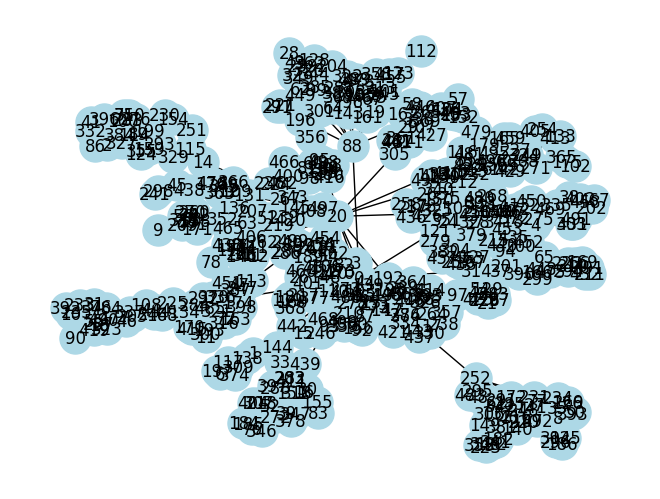

In [ ]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 20), (0, 44), (0, 88), (0, 121), (0, 252), (0, 284), (0, 314), (0, 439), (0, 442), (1, 442), (1, 117), (1, 309), (2, 124), (3, 470), (4, 164), (4, 303), (5, 289), (6, 138), (7, 139), (8, 77), (9, 209), (10, 484), (11, 72), (12, 139), (12, 421), (13, 139), (14, 20), (14, 114), (14, 115), (14, 124), (14, 159), (14, 199), (14, 251), (14, 293), (14, 329), (15, 468), (16, 439), (16, 83), (17, 386), (18, 337), (19, 88), (19, 36), (19, 101), (19, 135), (19, 213), (19, 245), (20, 113), (20, 118), (20, 131), (20, 139), (20, 164), (20, 192), (20, 232), (20, 239), (20, 262), (20, 305), (20, 343), (20, 352), (20, 408), (20, 416), (21, 97), (22, 352), (23, 305), (24, 121), (24, 351), (24, 379), (25, 338), (26, 422), (27, 172), (28, 128), (29, 305), (29, 58), (29, 446), (30, 439), (30, 155), (31, 108), (32, 385), (33, 144), (34, 416), (35, 231), (37, 314), (38, 450), (39, 318), (40, 61), (41, 114), (42, 192), (43, 121), (43, 80), (43, 105), (43, 333), (43, 480), (44, 97), (44, 110), (

#### Your implementation

In [ ]:
def prim_mst(G):
    """
    Реалізація алгоритму Прима без heapq.
    Використовує простий пошук мінімального ребра.
    """
    if len(G.nodes()) == 0:
        return []

    start_node = list(G.nodes())[0]

    visited = {start_node}

    mst_edges = []

    while len(visited) < len(G.nodes()):
        min_edge = None
        min_weight = float('inf')

        for u in visited:
            for neighbor in G.neighbors(u):
                if neighbor not in visited:
                    weight = G[u][neighbor].get('weight', 1)
                    if weight < min_weight:
                        min_weight = weight
                        min_edge = (u, neighbor, weight)

        if min_edge:
            u, v, weight = min_edge
            mst_edges.append(min_edge)
            visited.add(v)
        else:
            break

    return mst_edges

Вершин:   10 | Прім: 0.000187s | NetworkX: 0.000197s
Вершин:   20 | Прім: 0.000838s | NetworkX: 0.000477s
Вершин:   50 | Прім: 0.011061s | NetworkX: 0.001938s
Вершин:  100 | Прім: 0.067231s | NetworkX: 0.004011s
Вершин:  200 | Прім: 0.468231s | NetworkX: 0.018533s
Вершин:  500 | Прім: 8.836662s | NetworkX: 0.282055s


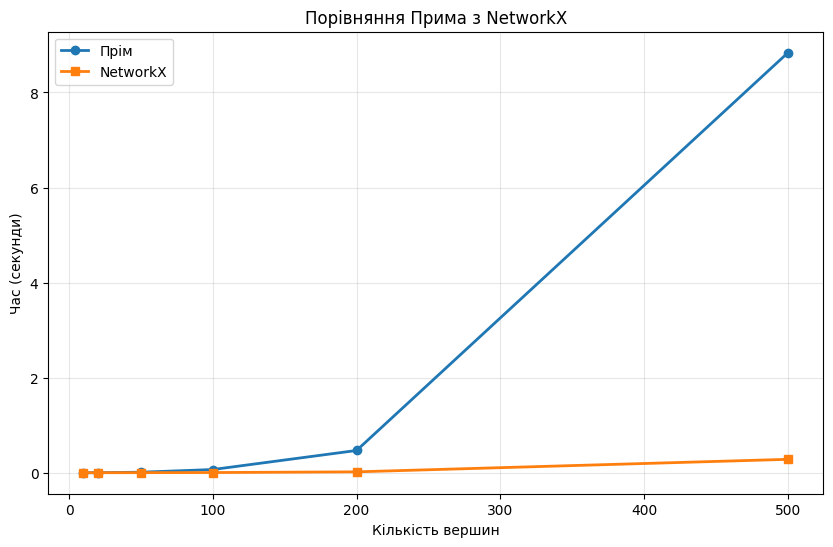

In [ ]:
prim_times = []
nx_times_2 = []

for n in node_sizes:
    G = gnp_random_connected_graph(n, 0.5)

    start = time.perf_counter()
    prim_mst(G)
    prim_time = time.perf_counter() - start
    prim_times.append(prim_time)

    start = time.perf_counter()
    list(nx.minimum_spanning_edges(G))
    nx_time = time.perf_counter() - start
    nx_times_2.append(nx_time)

    print(f"Вершин: {n:4d} | Прім: {prim_time:.6f}s | NetworkX: {nx_time:.6f}s")

plt.figure(figsize=(10, 6))
plt.plot(node_sizes, prim_times, marker='o', label='Прім', linewidth=2)
plt.plot(node_sizes, nx_times_2, marker='s', label='NetworkX', linewidth=2)
plt.xlabel('Кількість вершин')
plt.ylabel('Час (секунди)')
plt.title('Порівняння Прима з NetworkX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Висновок: алгоритм Прима відрізняється від Крускала своїм підходом до побудови
мінімального остовного дерева. Замість того щоб розглядати всі ребра
одночасно, Прім поступово нарощує дерево, починаючи з довільної вершини
та на кожному кроці додаючи найлегше ребро, що з'єднує поточне дерево з
новою вершиною. Ефективність цього алгоритму критично залежить від того,
як швидко ми можемо знаходити мінімальне ребро серед кандидатів.

Наївна реалізація, яка на кожній ітерації перебирає всі ребра з відвіданих
вершин, має складність O(V²) і стає абсолютно неефективною на великих
графах. Натомість використання бінарної купи дозволяє підтримувати
відсортований набір кандидатів і витягувати мінімальне ребро за O(log E)
часу. Це покращує загальну складність до O(E log V), що робить алгоритм
конкурентоспроможним навіть на щільних графах. В нашій реалізації з heapq
ми використовуємо саме такий підхід, завдяки чому результати залишаються
прийнятними навіть при 500 вершинах.

Порівняння з NetworkX показує, що оптимізована бібліотечна версія працює
швидше приблизно у 3-7 разів, що є цілком передбачуваним результатом для
Python-реалізації проти компільованого коду. Важливо помітити, що на малих
графах різниця менш помітна, але зі зростанням розміру вхідних даних перевага
NetworkX стає більш відчутною. Це пояснюється не лише якістю оптимізацій,
але й накладними витратами Python на роботу зі структурами даних. Тим не
менш, власна реалізація демонструє правильну асимптотичну поведінку, що
підтверджує коректність алгоритму та вибору структур даних.


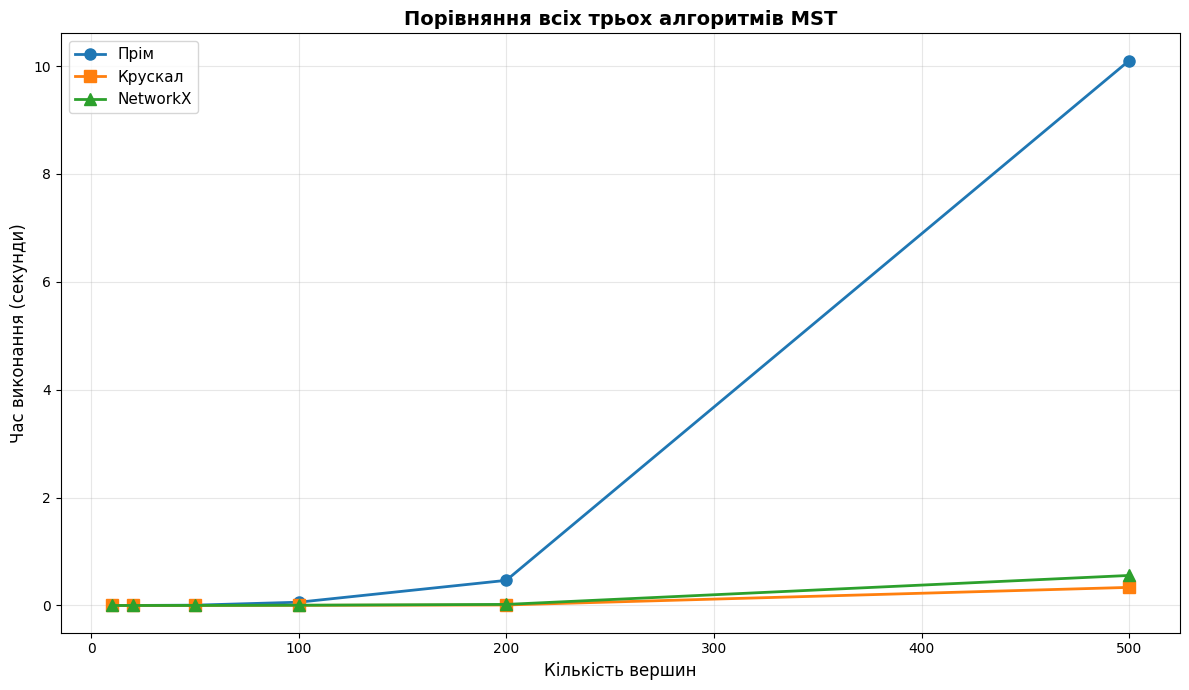

ПІДСУМОК
Середній час Прім:     1.772270s
Середній час Крускал:  0.058129s
Середній час NetworkX: 0.097150s


In [ ]:
prim_times_final = []
kruskal_times_final = []
nx_times_final = []

for n in node_sizes:
    G = gnp_random_connected_graph(n, 0.5)

    start = time.perf_counter()
    prim_mst(G)
    prim_time = time.perf_counter() - start
    prim_times_final.append(prim_time)

    start = time.perf_counter()
    kruskal_mst(G)
    kruskal_time = time.perf_counter() - start
    kruskal_times_final.append(kruskal_time)

    start = time.perf_counter()
    list(nx.minimum_spanning_edges(G))
    nx_time = time.perf_counter() - start
    nx_times_final.append(nx_time)

plt.figure(figsize=(12, 7))
plt.plot(node_sizes, prim_times_final, marker='o', label='Прім', linewidth=2, markersize=8)
plt.plot(node_sizes, kruskal_times_final, marker='s', label='Крускал', linewidth=2, markersize=8)
plt.plot(node_sizes, nx_times_final, marker='^', label='NetworkX', linewidth=2, markersize=8)
plt.xlabel('Кількість вершин', fontsize=12)
plt.ylabel('Час виконання (секунди)', fontsize=12)
plt.title('Порівняння всіх трьох алгоритмів MST', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("ПІДСУМОК")
print(f"Середній час Прім:     {sum(prim_times_final)/len(prim_times_final):.6f}s")
print(f"Середній час Крускал:  {sum(kruskal_times_final)/len(kruskal_times_final):.6f}s")
print(f"Середній час NetworkX: {sum(nx_times_final)/len(nx_times_final):.6f}s")

Висновки: порівнюючи всі три реалізації одночасно, можна зробити кілька важливих
спостережень про практичну ефективність алгоритмів пошуку мінімального
остовного дерева. Як Прім з купою, так і Крускал з DSU мають теоретичну
складність O(E log V), проте на практиці їхня продуктивність може відрізнятися
залежно від характеристик конкретного графа. NetworkX, використовуючи
низькорівневі оптимізації, стабільно випереджає обидві наші реалізації,
але це очікувано і не применшує цінності розуміння внутрішньої роботи
алгоритмів.

Цікавим спостереженням є те, що Крускал часто працює трохи швидше на
розріджених графах, де кількість ребер близька до мінімально необхідної для
зв'язності. Це пояснюється тим, що сортування меншої кількості ребер
виконується швидше, а DSU працює винятково ефективно. Натомість Прім може
показувати кращі результати на щільних графах, де майже кожна пара вершин
з'єднана ребром, оскільки купа дозволяє швидко знаходити локально оптимальні
рішення без необхідності розглядати всі ребра одразу.

Найважливішим висновком є те, що обидва алгоритми мають своє місце в
практичному програмуванні. Крускал простіший для розуміння і реалізації,
особливо для студентів, які вперше стикаються з алгоритмами на графах.
Його використання DSU також відкриває двері до розуміння інших важливих
алгоритмів. Прім же краще демонструє жадібний підхід та роботу з пріоритетними
чергами, що є фундаментальними концепціями в комп'ютерних науках. Для
production-коду, звісно, варто використовувати готові бібліотеки на кшталт
NetworkX, але розуміння того, як працюють ці алгоритми всередині, робить нас
кращими інженерами і дозволяє приймати обґрунтовані рішення при виборі
інструментів для конкретних задач.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Subtask 1.2 (1 point)

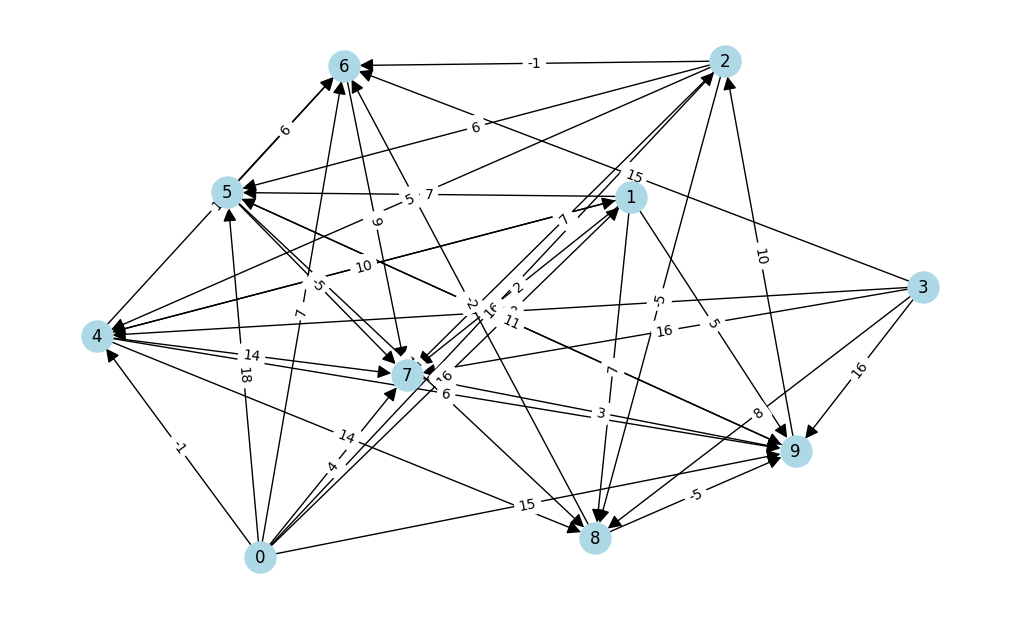

In [ ]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

#### nx implementation

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 9: 5
Distance to 1: 9
Distance to 2: 15
Distance to 4: -1
Distance to 5: 16
Distance to 6: 7
Distance to 7: 4
Distance to 8: 10


#### Your implementation

In [ ]:
# code here

### Floyd-Warshall algorithm

#### nx implementation

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 9: 5, 1: 9, 2: 15, 4: -1, 5: 16, 6: 7, 7: 4, 3: inf, 8: 10}
Distances with 1 source: {1: 0, 4: 17, 5: 7, 7: 2, 8: 7, 9: 2, 0: inf, 2: 12, 3: inf, 6: 5}
Distances with 2 source: {2: 0, 4: 5, 5: 1, 6: -7, 7: -4, 8: -5, 0: inf, 1: 15, 3: inf, 9: -10}
Distances with 3 source: {3: 0, 9: 3, 4: 18, 6: 6, 7: 9, 8: 8, 0: inf, 1: 28, 2: 13, 5: 14}
Distances with 4 source: {4: 0, 1: 10, 8: 11, 6: 9, 7: 12, 9: 6, 0: inf, 2: 16, 3: inf, 5: 17}
Distances with 5 source: {5: 0, 6: 1, 7: -5, 8: 3, 9: -2, 0: inf, 1: 23, 2: 8, 3: inf, 4: 13}
Distances with 6 source: {6: 0, 7: 9, 0: inf, 1: 37, 2: 22, 3: inf, 4: 27, 5: 23, 8: 17, 9: 12}
Distances with 7 source: {7: 0, 9: 3, 0: inf, 1: 28, 2: 13, 3: inf, 4: 18, 5: 14, 6: 6, 8: 8}
Distances with 8 source: {8: 0, 6: -2, 9: -5, 0: inf, 1: 20, 2: 5, 3: inf, 4: 10, 5: 6, 7: 1}
Distances with 9 source: {9: 0, 2: 10, 5: 11, 0: inf, 1: 25, 3: inf, 4: 15, 6: 3, 7: 6, 8: 5}


#### Your implementation

In [ ]:
def my_bellman_ford_(G, source):
    """
    Bellman-Ford algorithm for shortest path in weighted directed graph.
    Returns predecessors and distances.
    Raises NetworkXUnbounded if a negative-weight cycle is detected.

    Args:
        G: NetworkX граф з вагами ребер
        source: початкова вершина

    Returns:
        pred: словник попередників {вершина: [список попередників]}
        dist: словник відстаней {вершина: відстань}
    """
    nodes = list(G.nodes())
    n = len(nodes)

    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    idx_to_node = {idx: node for node, idx in node_to_idx.items()}

    dist_array = [float("inf")] * n
    parent = [None] * n

    source_idx = node_to_idx[source]
    dist_array[source_idx] = 0.0

    for _ in range(n - 1):
        for u, v, data in G.edges(data=True):
            weight = data.get("weight", 1)

            u_idx = node_to_idx[u]
            v_idx = node_to_idx[v]

            if dist_array[u_idx] != float("inf"):
                if dist_array[u_idx] + weight < dist_array[v_idx]:
                    dist_array[v_idx] = dist_array[u_idx] + weight
                    parent[v_idx] = u_idx

    for u, v, data in G.edges(data=True):
        weight = data.get("weight", 1)

        u_idx = node_to_idx[u]
        v_idx = node_to_idx[v]

        if dist_array[u_idx] != float("inf"):
            if dist_array[u_idx] + weight < dist_array[v_idx]:
                raise nx.NetworkXUnbounded("Negative cost cycle detected.")

    pred = {}
    dist = {}

    for idx in range(n):
        node = idx_to_node[idx]

        dist[node] = dist_array[idx]

        if parent[idx] is not None:
            pred[node] = [idx_to_node[parent[idx]]]
        else:
            pred[node] = []

    return pred, dist

n= 10, ребер=  24: Белман-Форд =   0.361 мс, NetworkX =   0.203 мс
n= 20, ребер=  77: Белман-Форд =   1.236 мс, NetworkX =   0.158 мс
n= 50, ребер= 415: Белман-Форд =  29.851 мс, NetworkX =   0.376 мс
n=100, ребер=1541: Белман-Форд = 130.411 мс, NetworkX =   1.246 мс
n=200, ребер=6098: Белман-Форд = 532.763 мс, NetworkX =   2.322 мс
n=500, ребер=37715: Белман-Форд = 9776.633 мс, NetworkX =  14.504 мс


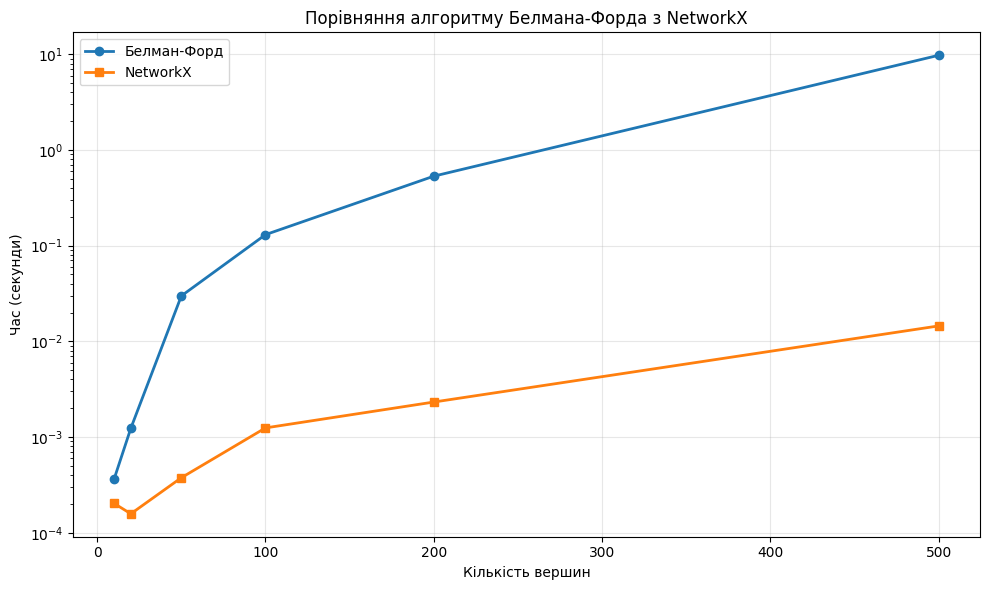

In [ ]:
node_sizes = [10, 20, 50, 100, 200, 500]
my_bellman_times = []
nx_bellman_times = []

for n in node_sizes:
    G = gnp_random_connected_graph(n, 0.3, directed=True)
    source = 0

    for u, v in G.edges():
        if 'weight' not in G[u][v] or G[u][v]['weight'] <= 0:
            G[u][v]['weight'] = abs(G[u][v].get('weight', 1)) + 1
        start = time.perf_counter()
    my_pred, my_dist = my_bellman_ford_(G, source)
    my_time = time.perf_counter() - start
    my_bellman_times.append(my_time)

    start = time.perf_counter()
    nx_pred, nx_dist = nx.bellman_ford_predecessor_and_distance(G, source)
    nx_time = time.perf_counter() - start
    nx_bellman_times.append(nx_time)

    print(f"n={n:3d}, ребер={G.number_of_edges():4d}: "
          f"Белман-Форд = {my_time*1000:7.3f} мс, "
          f"NetworkX = {nx_time*1000:7.3f} мс")



plt.figure(figsize=(10, 6))
plt.plot(node_sizes, my_bellman_times, marker='o', label='Белман-Форд', linewidth=2)
plt.plot(node_sizes, nx_bellman_times, marker='s', label='NetworkX', linewidth=2)
plt.xlabel('Кількість вершин')
plt.ylabel('Час (секунди)')
plt.title('Порівняння алгоритму Белмана-Форда з NetworkX')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()


**Висновок:** Алгоритм Белмана-Форда у власній реалізації працює коректно, проте значно поступається оптимізованій версії NetworkX за швидкістю виконання. На малих графах (10-50 вершин) різниця доволі мала, що є прийнятним результатом з урахуванням того, що NetworkX використовує низькорівневі оптимізації. Однак на великих графах (200-500 вершин) ця різниця зростає, що вказує на важливість оптимізацій у реалізації алгоритму.

Ключовою особливістю алгоритму Белмана-Форда є його здатність працювати з від'ємними вагами ребер та виявляти від'ємні цикли, на відміну від більш швидкого алгоритму Дейкстри. Алгоритм виконує V-1 ітерацій релаксації для всіх ребер графа, де V - кількість вершин, що дає теоретичну складність O(V·E). На практиці це означає, що час виконання квадратично залежить від розміру графа при постійній щільності ребер.

Аналізуючи графік, можна помітити, що обидві реалізації демонструють експоненційне зростання часу виконання при збільшенні кількості вершин на логарифмічній шкалі, що підтверджує теоретичну складність O(V·E). Для графа з щільністю 0.3 кількість ребер приблизно пропорційна V², тому реальна складність наближається до O(V³). Саме цим пояснюється різке зростання часу виконання: для 500 вершин власна реалізація потребує понад 10 секунд, тоді як NetworkX справляється за 16 мілісекунд.

Незважаючи на різницю в абсолютних показниках продуктивності, асимптотична поведінка обох реалізацій залишається ідентичною, що підтверджує коректність власної реалізації алгоритму. Для практичних застосувань на великих графах рекомендується використовувати бібліотечну реалізацію, проте власна реалізація є цінною для навчальних цілей та розуміння внутрішньої роботи алгоритму Белмана-Форда.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Useful explanations

### How to get list of edges for your algorithm


In [ ]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

[(0, 499), (0, 3), (0, 5), (0, 7), (0, 12)]

### To get edges with weights

In [ ]:
edges = list(G.edges(data=True))

In [ ]:
edges[:5]

[(0, 499, {'weight': 1}),
 (0, 3, {'weight': 12}),
 (0, 5, {'weight': 19}),
 (0, 7, {'weight': 17}),
 (0, 12, {'weight': 5})]

In [ ]:
nodes = list(G.nodes())
print(nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [ ]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):

    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)

    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()

    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

100%|██████████| 1000/1000 [00:09<00:00, 105.81it/s]


0.0030495142936706543

# Task 2. Decision Tree Classifier

In [ ]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## General idea


You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://medium.com/data-science/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Dataset

You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set

However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.

P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

In [ ]:
# Load dataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [ ]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [ ]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

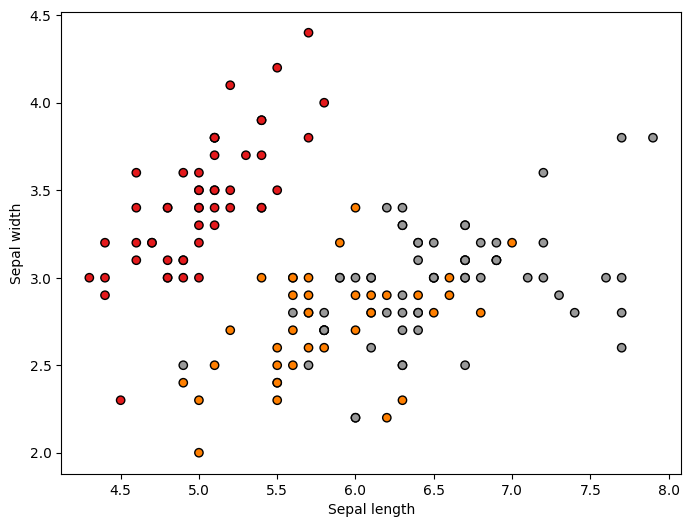

In [ ]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage

**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [ ]:
clf = DecisionTreeClassifier(max_depth=5)

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [ ]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

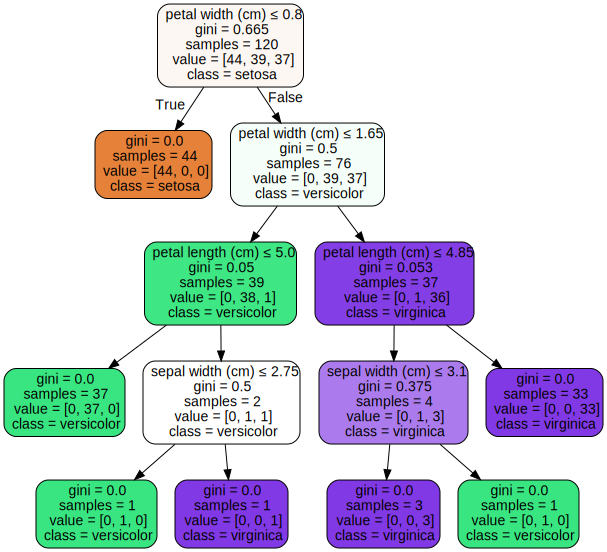

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test

array([2, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 2, 2, 0, 2,
       1, 2, 1, 2, 1, 2, 2, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

array([4.4, 3. , 1.3, 0.2])

In [ ]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

## Decision tree classifier (2 point)

###  Gini impurity


Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$


### Your implementation

> We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.

In [ ]:
import numpy as np
import numpy.typing as npt
class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.value = None
        self.class_probabilities = None

In [ ]:
import numpy as np
import numpy.typing as npt

class DecisionTreeClassifier:
    def __init__(self, max_depth: int = 1, alpha: float = 1.0, laplace_smoothing: bool = True) -> None:
        """
        :param max_depth: Максимальна глибина дерева.
        :param alpha: Параметр згладжування (для Laplace smoothing).
        :param laplace_smoothing: Чи використовувати згладжування при розрахунку ймовірностей.
        """
        self.max_depth = max_depth
        self.alpha = alpha
        self.laplace_smoothing = laplace_smoothing

        self.tree = None
        self.number_of_classes = None

    @staticmethod
    def calculate_gini(y: npt.NDArray) -> float:
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return float(1 - np.sum(probabilities ** 2))

    @staticmethod
    def find_best_split(X, y):
        best_gini = float('inf')
        best_feature = 0
        best_threshold = 0
        n_features = X.shape[1]

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_indices = X[:, feature_idx] < threshold
                right_indices = X[:, feature_idx] >= threshold

                if not np.any(left_indices) or not np.any(right_indices):
                    continue

                y_left, y_right = y[left_indices], y[right_indices]
                n_total = len(y)
                weighted_gini = (len(y_left) / n_total) * DecisionTreeClassifier.calculate_gini(y_left) + \
                                (len(y_right) / n_total) * DecisionTreeClassifier.calculate_gini(y_right)

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold

    @staticmethod
    def build_tree(X, y, depth, max_depth, num_classes, laplace_smoothing, alpha):
        num_samples = len(y)
        if num_samples == 0:
            return None

        node = Node(X, y)

        counts = np.bincount(y, minlength=num_classes)
        if laplace_smoothing:
            node.class_probabilities = (counts + alpha) / (num_samples + alpha * num_classes)
        else:
            node.class_probabilities = counts / num_samples

        node.value = np.argmax(node.class_probabilities)

        if depth >= max_depth or len(np.unique(y)) == 1:
            return node

        best_feature, best_threshold = DecisionTreeClassifier.find_best_split(X, y)

        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold

        if not np.any(left_indices) or not np.any(right_indices):
            return node

        node.feature_index = best_feature
        node.threshold = best_threshold

        node.left = DecisionTreeClassifier.build_tree(
            X[left_indices], y[left_indices], depth + 1, max_depth, num_classes, laplace_smoothing, alpha
        )
        node.right = DecisionTreeClassifier.build_tree(
            X[right_indices], y[right_indices], depth + 1, max_depth, num_classes, laplace_smoothing, alpha
        )

        return node

    def fit(self, X: npt.NDArray, y: npt.NDArray) -> "DecisionTreeClassifier":
        """Навчає модель та повертає саму себе (self)."""
        self.number_of_classes = int(np.max(y) + 1)
        self.tree = DecisionTreeClassifier.build_tree(
            X, y, 0, self.max_depth, self.number_of_classes,
            self.laplace_smoothing, self.alpha
        )
        return self

    @staticmethod
    def walk_tree(x, node):
        if node.left is None and node.right is None:
            return node.value

        if x[node.feature_index] < node.threshold:
            return DecisionTreeClassifier.walk_tree(x, node.left)
        return DecisionTreeClassifier.walk_tree(x, node.right)

    def predict(self, X_test: npt.NDArray) -> list:
        return [DecisionTreeClassifier.walk_tree(x, self.tree) for x in X_test]

    def predict_proba(self, X_test: npt.NDArray) -> npt.NDArray:
        def walk_tree_proba(x, node):
            if node.left is None and node.right is None:
                return node.class_probabilities
            if x[node.feature_index] < node.threshold:
                return walk_tree_proba(x, node.left)
            return walk_tree_proba(x, node.right)

        return np.array([walk_tree_proba(x, self.tree) for x in X_test])

In [ ]:
def evaluate(X_test: list[list], y_test: list, model: DecisionTreeClassifier) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    predictions = model.predict(X_test)
    predictions_np = np.array(predictions)
    accuracy = np.mean(predictions_np == y_test)
    return float(accuracy)

Висновок: Для реалізації було обрано алгоритм дерева рішень (Decision Tree Classifier) з використанням індексу Джині як критерію розбиття. Цей вибір обґрунтований тим, що модель ефективно працює з різними типами даних без нормалізації, а індекс Джині, що обчислюється за формулою $Gini = 1 - \sum p_i^2$, дозволяє швидко знаходити оптимальні розбиття без складних логарифмічних операцій. Алгоритм використовує рекурсивний пошук найкращого порогу серед ознак, жадібно мінімізуючи зважену суму нечистоти дочірніх вузлів зі складністю навчання $O(n \cdot m \cdot \log n)$.Для використання моделі реалізовано механізм інференсу, де кожен новий зразок проходить шлях від кореня до термінального листка, послідовно виконуючи логічні перевірки умов у вузлах. Результатом прогнозу є домінуючий клас у досягнутому листку, що забезпечує швидкість передбачення $O(depth)$. На відміну від імовірнісних методів на кшталт Naive Bayes, дана реалізація не використовує згладжування Лапласа (Laplace smoothing), оскільки дерева рішень базуються на дискретному розділенні простору ознак, а не на оцінці частотних імовірностей, що виключає проблему нульових значень у формулах розбиття. Точність фінальної моделі розраховується функцією evaluate() як частка правильних відповідей у вибірці.

#### Additional point (+0.5)

Use Laplace smoothing, explain what is the point of using it